<a href="https://colab.research.google.com/github/airctic/icevision/blob/master/notebooks/mask_rcnn_pennfundan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How to use Mask RCNN

## Installing IceVision

In [ ]:
!pip install icevision[all]
!pip install icedata

## Imports

As usual, we import everything from IceVision.

In [3]:
from icevision.all import *
import icedata

## Data

We'll be using the [Penn-Fundan](https://www.cis.upenn.edu/~jshi/ped_html/) dataset, which is already available under `datasets`.

In [25]:
data_dir = icedata.pennfudan.load_data()
class_map = icedata.pennfudan.class_map()

As usual, let's create the parser and perfom a random data split.

In [6]:
parser = icedata.pennfundan.parser(data_dir)

data_splitter = RandomSplitter([0.8, 0.2])
train_records, valid_records = parser.parse(data_splitter)

Let's use the usual `aug_tfms` for training transforms with two small modifications:
- Decrease the rotation limit from 45 to 10.
- Use a more aggresive crop function.

In [7]:
shift_scale_rotate = tfms.A.ShiftScaleRotate(rotate_limit=10)
crop_fn = partial(tfms.A.RandomSizedCrop, min_max_height=(384//2, 384), p=.5)
train_tfms = tfms.A.Adapter(
    [
        *tfms.A.aug_tfms(size=384, presize=512, shift_scale_rotate=shift_scale_rotate, crop_fn=crop_fn),
        tfms.A.Normalize(),
    ]
)

And for validation transforms, the simple `resize_and_pad`.

In [8]:
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(size=348), tfms.A.Normalize()])

Now we can create the `Dataset` and take a look on how the images look after the transforms.

In [9]:
train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)

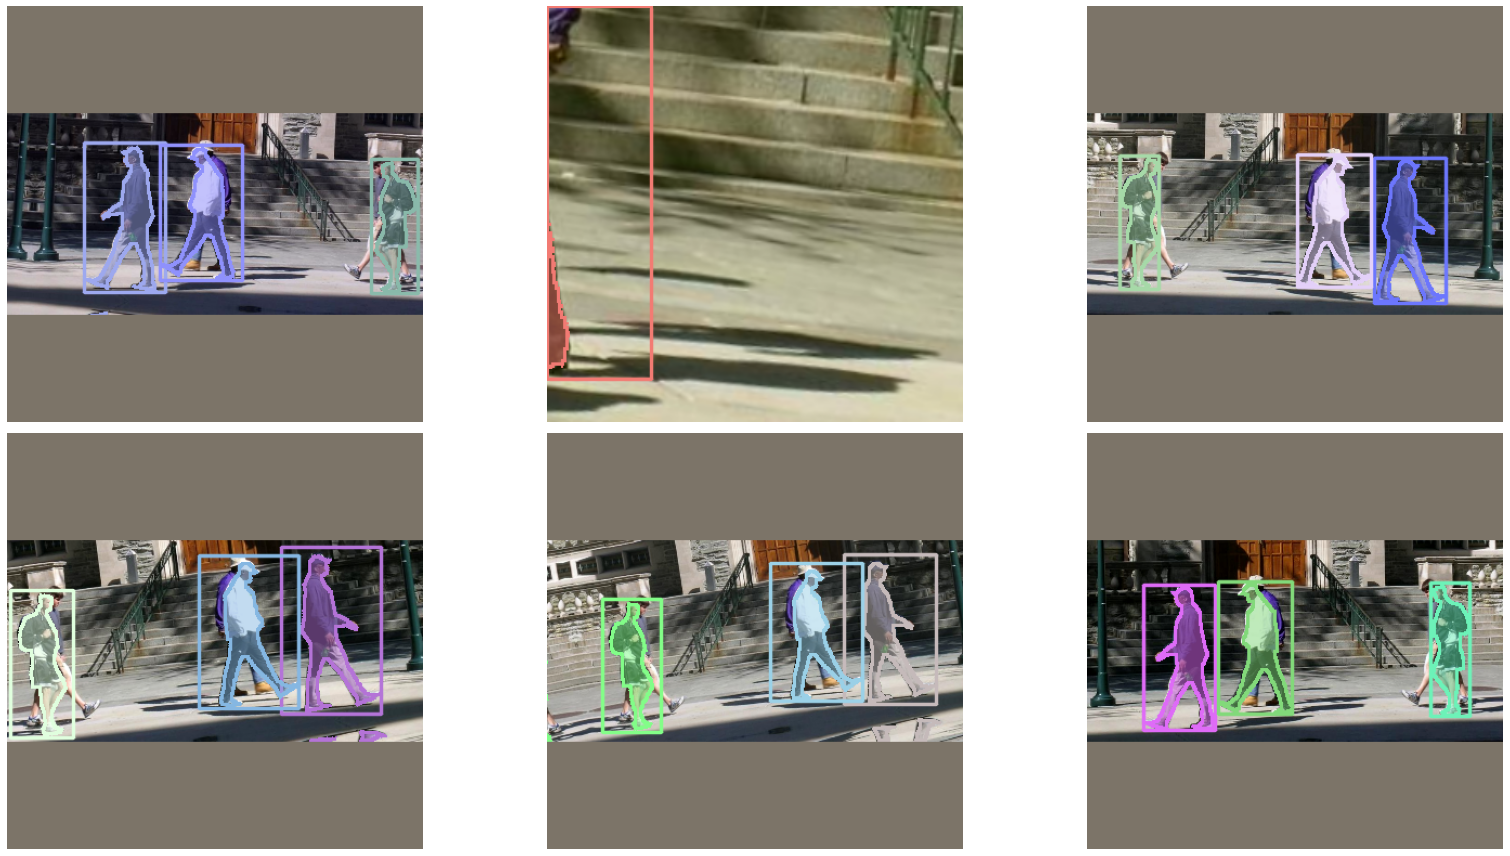

In [24]:
samples = [train_ds[1] for _ in range(6)]
show_samples(samples, denormalize_fn=denormalize_imagenet, ncols=3, display_label=False, show=True)

Now we're ready to create the DataLoaders:

In [12]:
train_dl = mask_rcnn.train_dl(train_ds, batch_size=16, shuffle=True, num_workers=4)
valid_dl = mask_rcnn.valid_dl(valid_ds, batch_size=16, shuffle=False, num_workers=4)

## Metrics

Metrics are a work in progress for Mask RCNN.

In [ ]:
# metrics = [COCOMetric(COCOMetricType.mask)]

## Model

Similarly to `faster_rcnn`, we just need the `num_classes` to create a Mask RCNN model.

In [21]:
model = mask_rcnn.model(num_classes=len(class_map))

## Training - fastai

We just need to create the learner and fine-tune.

!!! info "Optional"  
    You can use `learn.lr_find()` for finding a good learning rate.

In [19]:
learn = mask_rcnn.fastai.learner(dls=[train_dl, valid_dl], model=model)

In [20]:
learn.fine_tune(10, 5e-4, freeze_epochs=2)

## Visualize predictions

Let's grab some images from `valid_ds` to visualize. For more info on how to do inference, check the [inference tutorial](https://airctic.github.io/icevision/inference/).

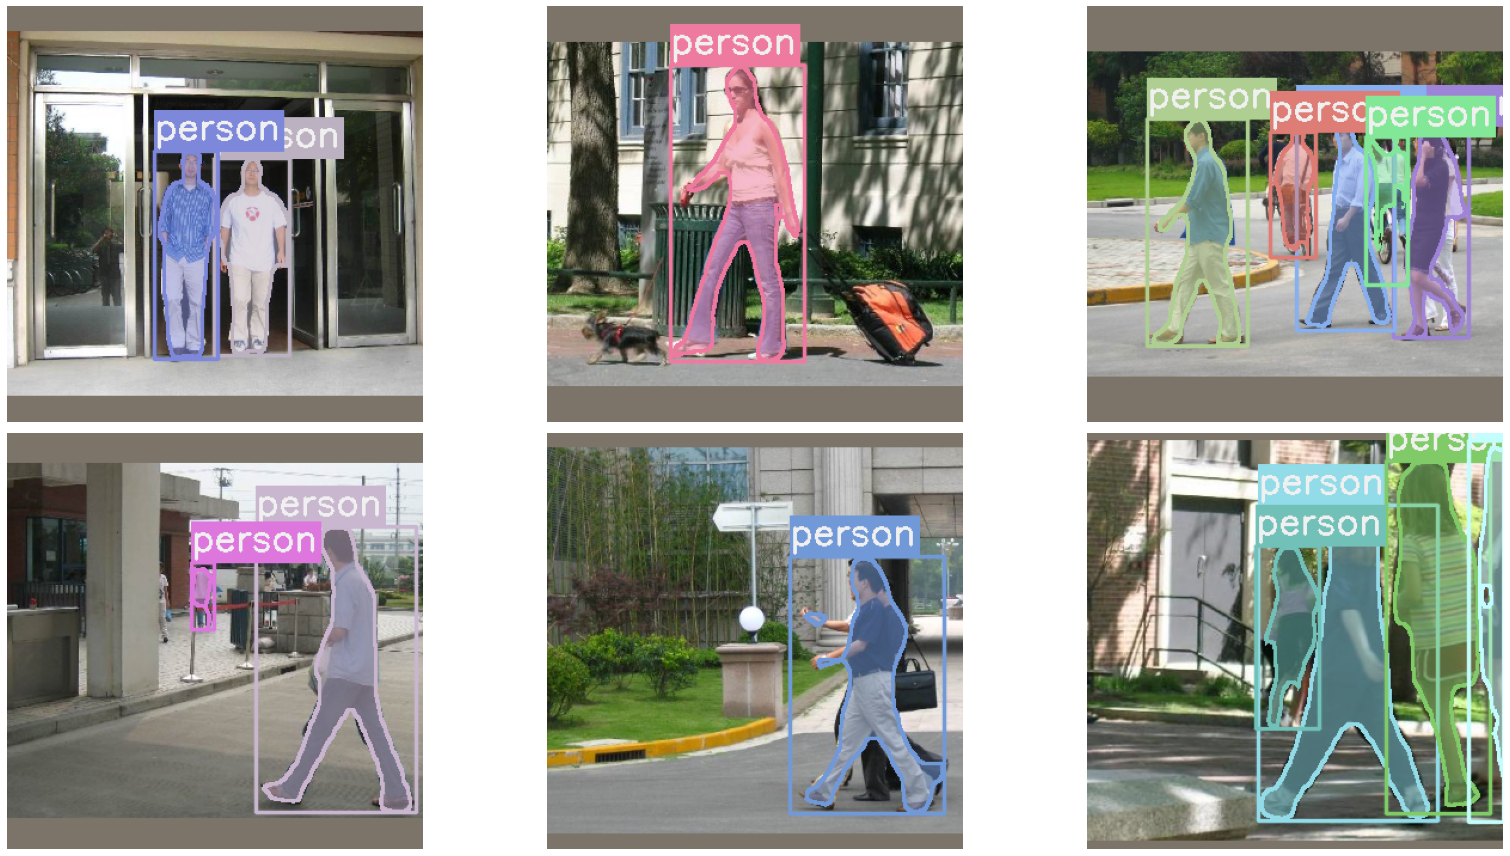

In [18]:
mask_rcnn.show_results(model, valid_ds, class_map=class_map)

## Happy Learning!

If you need any assistance, feel free to join our [forum](https://spectrum.chat/mantis).